In [53]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import KNNImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import *

In [2]:

data = pd.read_csv('data/data.csv')

# Convert 'date' to datetime format and set as index
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

data.head(), data.tail(), data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26904 entries, 2020-09-20 00:00:00 to 2023-10-15 23:00:00
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   power   26685 non-null  float64
 1   exog    26645 non-null  float64
dtypes: float64(2)
memory usage: 630.6 KB


(                        power    exog
 date                                 
 2020-09-20 00:00:00   976.930  11.805
 2020-09-20 01:00:00   952.705  11.446
 2020-09-20 02:00:00   928.813  11.218
 2020-09-20 03:00:00   984.234  11.025
 2020-09-20 04:00:00  1002.113  11.196,
                      power    exog
 date                              
 2023-10-15 19:00:00    NaN  10.820
 2023-10-15 20:00:00    NaN  10.619
 2023-10-15 21:00:00    NaN   9.535
 2023-10-15 22:00:00    NaN  10.031
 2023-10-15 23:00:00    NaN   9.464,
 None)

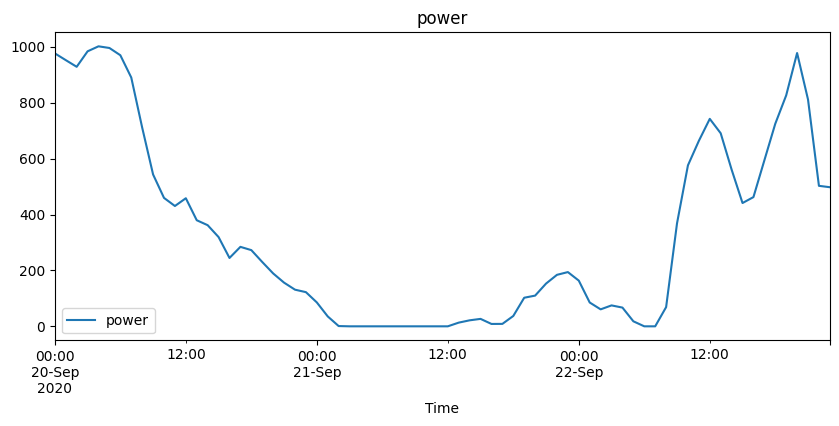

In [39]:
data[["power"]][0:72].plot()
plt.xlabel('Time')
plt.title('power')
plt.show()

In [3]:
# Initialize KNNImputer
knn_imputer = KNNImputer(n_neighbors=5)

# Separate the last 168 rows for prediction
data_for_imputation = data.iloc[:-168, :]
data_to_predict = data.iloc[-168:, :]

# Impute missing values in 'exog' for the whole dataset
data['exog'] = knn_imputer.fit_transform(data[['exog']])

# Impute missing values in 'power' except for the last 168 values
data_for_imputation['power'] = knn_imputer.fit_transform(data_for_imputation[['power']])

# Combine the data back
data_imputed = pd.concat([data_for_imputation, data_to_predict])

# Check if there are any missing values left in 'exog' and 'power' (except for the last 168 values)
data_imputed.isnull().sum(), data_imputed.tail()


/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8133/704053833.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_imputation['power'] = knn_imputer.fit_transform(data_for_imputation[['power']])


(power    168
 exog     259
 dtype: int64,
                      power    exog
 date                              
 2023-10-15 19:00:00    NaN  10.820
 2023-10-15 20:00:00    NaN  10.619
 2023-10-15 21:00:00    NaN   9.535
 2023-10-15 22:00:00    NaN  10.031
 2023-10-15 23:00:00    NaN   9.464)

In [25]:
data_imputed

,power,exog
date,,
2020-09-20 00:00:00,976.930,11.805
2020-09-20 01:00:00,952.705,11.446
2020-09-20 02:00:00,928.813,11.218
2020-09-20 03:00:00,984.234,11.025
2020-09-20 04:00:00,1002.113,11.196
...,...,...
2023-10-15 19:00:00,NaN,10.820
2023-10-15 20:00:00,NaN,10.619
2023-10-15 21:00:00,NaN,9.535


In [43]:

import numpy as np

# Since 'data_imputed' already includes 'exog' and 'power' imputed where possible, we proceed with feature engineering
# Re-defining the feature engineering function to include necessary adjustments and enhancements
def build_some_features(df_, target, num_periods_lagged=3, num_periods_diffed=1, weekday=False, month=True, rolling=[np.mean, np.min, np.max, np.std], holidays=False):
    df_ = df_.copy()
            
    for i in range(1, num_periods_lagged+1):
        df_['lagged_%s' % i] = df_[target].shift(i)
        
    for i in range(1, num_periods_diffed+1):
        df_['diff_%s' % i] = df_[target].diff(i)
    
    if rolling:
        for stat in rolling:
            df_['rolling_%s'%str(stat)] = df_[target].rolling('30D').aggregate(stat)
        
    if weekday:
        df_['sin_weekday'] = np.sin(2 * np.pi * df_.index.dayofweek / 7)
        df_['cos_weekday'] = np.cos(2 * np.pi * df_.index.dayofweek / 7)
        
    if month:
        df_['sin_month'] = np.sin(2 * np.pi * df_.index.month / 12)
        df_['cos_month'] = np.cos(2 * np.pi * df_.index.month / 12)
        
    if holidays:
        # Placeholder for holidays; in a real scenario, you'd match specific dates
        df_['holidays'] = ((df_.index.month == 12) & (df_.index.day == 25)) | ((df_.index.month == 1) & (df_.index.day == 1)).astype(int)
        
    df_.fillna(method='ffill', inplace=True)
    
    return df_

# Apply feature engineering to the dataset
data_fe = build_some_features(data_imputed, 'power')

# Check the engineered dataset
data_fe.isnull().sum(), data_fe.head()


/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8133/3206331035.py:16: FutureWarning: The provided callable <function mean at 0x11032eb00> is currently using Rolling.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'mean' instead.
  df_['rolling_%s'%str(stat)] = df_[target].rolling('30D').aggregate(stat)
/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8133/3206331035.py:16: FutureWarning: The provided callable <function min at 0x11032e320> is currently using Rolling.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass 'min' instead.
  df_['rolling_%s'%str(stat)] = df_[target].rolling('30D').aggregate(stat)
/var/folders/dk/djl_jn195h7gym2_kn27310c0000gn/T/ipykernel_8133/3206331035.py:16: FutureWarning: The provided callable <function max at 0x11032e200> is currently using Rolling.max. In a future version of pandas, the provided callable will be u

(power                                     0
 exog                                      0
 lagged_1                                  1
 lagged_2                                  2
 lagged_3                                  3
 diff_1                                    1
 rolling_<function mean at 0x11032eb00>    0
 rolling_<function min at 0x11032e320>     0
 rolling_<function max at 0x11032e200>     0
 rolling_<function std at 0x11032ec20>     1
 sin_month                                 0
 cos_month                                 0
 dtype: int64,
                         power    exog  lagged_1  lagged_2  lagged_3  diff_1  \
 date                                                                          
 2020-09-20 00:00:00   976.930  11.805       NaN       NaN       NaN     NaN   
 2020-09-20 01:00:00   952.705  11.446   976.930       NaN       NaN -24.225   
 2020-09-20 02:00:00   928.813  11.218   952.705   976.930       NaN -23.892   
 2020-09-20 03:00:00   984.234  11.025   928.

In [5]:
#from sklearn.metrics import mean_absolute_error
#
## Preparing the data for training and prediction
## Drop rows with NaN in the target column 'power' for training data
#train_df = data_fe.iloc[:-168].dropna(subset=['power'])
#predict_df = data_fe.iloc[-168:]  # Data for prediction
#
## Define features and target
#X_train = train_df.drop('power', axis=1)
#y_train = train_df['power']
#X_predict = predict_df.drop('power', axis=1)
#
## Initialize the GradientBoostingRegressor model
#gb_regressor = GradientBoostingRegressor()
#
## Train the model
#gb_regressor.fit(X_train, y_train)
#
## Predict the last 168 missing values of 'power'
#power_predictions = gb_regressor.predict(X_predict)
#
## As we don't have true values for the last 168 hours, we skip direct MAE calculation.
## Normally, you'd calculate it like this if you had true values:
## mae = mean_absolute_error(y_true, power_predictions)
#
## Insert the predicted values back into the dataset
#data_fe.loc[data_fe.index[-168:], 'power'] = power_predictions
#
## Display the first few predicted values
#power_predictions[:5]
#

In [6]:
## Apply forward fill to handle NaNs resulting from feature engineering
#data_fe_filled = data_fe.ffill().bfill()  # Forward fill followed by backward fill to cover all NaNs
#
## Prepare the data again for training and prediction
#X_train_filled = data_fe_filled.iloc[:-168].drop('power', axis=1)  # Exclude last 168 hours for features
#y_train_filled = data_fe_filled.iloc[:-168]['power']  # Exclude last 168 hours for target
#X_predict_filled = data_fe_filled.iloc[-168:].drop('power', axis=1)  # Features for prediction
#
## Re-initialize and train the GradientBoostingRegressor model
#gb_regressor = GradientBoostingRegressor()
#gb_regressor.fit(X_train_filled, y_train_filled)
#
## Re-predict the last 168 missing values of 'power'
#power_predictions_filled = gb_regressor.predict(X_predict_filled)
#
## Insert the predicted values back into the dataset
#data_fe_filled.loc[data_fe_filled.index[-168:], 'power'] = power_predictions_filled
#
## Display the first few predicted values as a check
#power_predictions_filled[:5]
#

In [44]:
from sklearn.metrics import mean_absolute_error

# Apply forward fill to handle NaNs resulting from feature engineering
data_fe_filled = data_fe.ffill().bfill()  

# Prepare the data for training, testing, and prediction
# Exclude last 168*2 hours for training to reserve the last 168 hours for testing and the final 168 hours for prediction
X_train_filled = data_fe_filled.iloc[:-336].drop('power', axis=1)  
y_train_filled = data_fe_filled.iloc[:-336]['power']  

# Define the test set (the 168 hours before the last 168 hours)
X_test_filled = data_fe_filled.iloc[-336:-168].drop('power', axis=1)
y_test_filled = data_fe_filled.iloc[-336:-168]['power']

# Features for the final prediction
X_predict_filled = data_fe_filled.iloc[-168:].drop('power', axis=1)  

# Re-initialize and train the GradientBoostingRegressor model
gb_regressor = GradientBoostingRegressor()
gb_regressor.fit(X_train_filled, y_train_filled)

# Predict on the test set to evaluate the model
test_predictions = gb_regressor.predict(X_test_filled)

# Calculate Mean Absolute Error (MAE) on the test set
mae_test = mean_absolute_error(y_test_filled, test_predictions)
print("Mean Absolute Error (MAE) on Test Set:", mae_test)

# Predict the last 168 missing values of 'power'
power_predictions_filled = gb_regressor.predict(X_predict_filled)

# Insert the predicted values back into the dataset for the last 168 hours
data_fe_filled.loc[data_fe_filled.index[-168:], 'power'] = power_predictions_filled

# Display the first few predicted values as a check
power_predictions_filled[:5]


Mean Absolute Error (MAE) on Test Set: 8.702633306427593


array([697.95629059, 697.95629059, 697.95629059, 697.95629059,
       697.95629059])

In [45]:
len(y_test_filled), len(power_predictions_filled)

(168, 168)

In [46]:
mae_gb = mean_absolute_error(y_test_filled, test_predictions)

In [47]:
mae_gb

8.702633306427593

In [11]:
#submission = pd.DataFrame(data=power_predictions_filled, columns=["power"])
#submission.to_csv("submission2.csv", index=False)
submission

,power
0,700.694223
1,701.228215
2,700.890074
3,700.890074
4,700.890074
...,...
163,700.890074
164,700.890074
165,700.890074
166,700.890074


In [36]:
y_test_filled

date
2023-10-02 00:00:00    149.314
2023-10-02 01:00:00     83.634
2023-10-02 02:00:00     58.508
2023-10-02 03:00:00     17.775
2023-10-02 04:00:00     17.595
                        ...   
2023-10-08 19:00:00    551.124
2023-10-08 20:00:00    699.824
2023-10-08 21:00:00    922.044
2023-10-08 22:00:00    897.264
2023-10-08 23:00:00    797.614
Name: power, Length: 168, dtype: float64

In [37]:
pd.Series(power_predictions_filled, index=y_test_filled.index)

date
2023-10-02 00:00:00    700.700029
2023-10-02 01:00:00    701.223632
2023-10-02 02:00:00    700.885158
2023-10-02 03:00:00    700.885158
2023-10-02 04:00:00    700.885158
                          ...    
2023-10-08 19:00:00    700.885158
2023-10-08 20:00:00    700.885158
2023-10-08 21:00:00    700.885158
2023-10-08 22:00:00    700.885158
2023-10-08 23:00:00    700.885158
Length: 168, dtype: float64

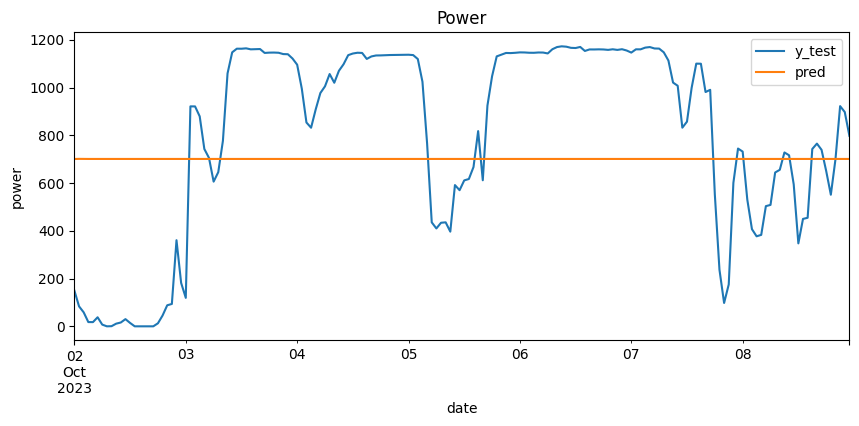

In [38]:
plt.rcParams['figure.figsize'] = (10, 4)
y_test_filled.plot(label="y_test")
plt.ylabel('power')
pd.Series(power_predictions_filled, index=y_test_filled.index).plot(label="pred")
plt.title('Power')
plt.legend()
plt.show()

In [57]:
X_train_filled

,exog,lagged_1,lagged_2,lagged_3,diff_1,rolling_<function mean at 0x11032eb00>,rolling_<function min at 0x11032e320>,rolling_<function max at 0x11032e200>,rolling_<function std at 0x11032ec20>,sin_month,cos_month
date,,,,,,,,,,,
2020-09-20 00:00:00,11.805,976.930,976.930,976.930,-24.225,976.930000,976.930,976.930,17.129662,-1.000000,-1.836970e-16
2020-09-20 01:00:00,11.446,976.930,976.930,976.930,-24.225,964.817500,952.705,976.930,17.129662,-1.000000,-1.836970e-16
2020-09-20 02:00:00,11.218,952.705,976.930,976.930,-23.892,952.816000,928.813,976.930,24.058692,-1.000000,-1.836970e-16
2020-09-20 03:00:00,11.025,928.813,952.705,976.930,55.421,960.670500,928.813,984.234,25.152597,-1.000000,-1.836970e-16
2020-09-20 04:00:00,11.196,984.234,928.813,952.705,17.879,968.959000,928.813,1002.113,28.600455,-1.000000,-1.836970e-16
...,...,...,...,...,...,...,...,...,...,...,...
2023-10-01 19:00:00,8.240,616.574,686.953,978.194,-130.380,421.027256,0.000,1174.422,413.966288,-0.866025,5.000000e-01
2023-10-01 20:00:00,7.155,486.194,616.574,686.953,-167.260,421.267118,0.000,1174.422,413.856864,-0.866025,5.000000e-01
2023-10-01 21:00:00,8.565,318.934,486.194,616.574,-184.930,421.313131,0.000,1174.422,413.823032,-0.866025,5.000000e-01


In [58]:
X_train_filled.isnull().sum()

exog                                      0
lagged_1                                  0
lagged_2                                  0
lagged_3                                  0
diff_1                                    0
rolling_<function mean at 0x11032eb00>    0
rolling_<function min at 0x11032e320>     0
rolling_<function max at 0x11032e200>     0
rolling_<function std at 0x11032ec20>     0
sin_month                                 0
cos_month                                 0
dtype: int64

In [56]:
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from joblib import Parallel, delayed
from tqdm import tqdm
import numpy as np
import pandas as pd

# Define the parameter grid for model selection
param_grid = {
    'model': [LinearRegression(), GradientBoostingRegressor()],
    'num_periods_lagged': [0, 1, 2, 24],
    'num_periods_diffed': [0],
    'hour': [True],
    'weekday': [False],
    'month': [True],
    'holidays': [False],
    'rolling': [[], [np.mean, np.min, np.max, np.std]]
}

# Initialize the parameter grid
grid = ParameterGrid(param_grid)

# Define the function for model selection
def wrap_model_selection(params, train, val): 
    predictions = predict_n_periods(
        series_=train, 
        n_periods=len(val), 
        model=params['model'], 
        num_periods_lagged=params['num_periods_lagged'],
        num_periods_diffed=params['num_periods_diffed'],
        hour=params['hour'],
        month=params['month'],
        rolling=params["rolling"],
        holidays=params['holidays'],
        target="power"  # Assuming 'power' is the target column to predict
    )
    return [params, mean_absolute_error(val['power'], predictions)]

# Prepare your data (assuming 'data' is your DataFrame and 'power' is the target column)
# Here you should split your data into 'train', 'val', and 'test' sets appropriately

# Execute the model selection in parallel
# Replace 'train' and 'val' with your actual training and validation sets
res = Parallel(n_jobs=-1)(delayed(wrap_model_selection)(params=params, train=X_train_filled, val=X_test_filled) 
                          for params in tqdm(grid))

# Create a DataFrame to store the results
df = pd.DataFrame(res, columns=['params', 'error'])

# Sort the results to find the best parameters based on the error
df_sorted = df.sort_values(by='error')

# Assuming 'test' is your actual test set, make final predictions with the best model
best_params = df_sorted.iloc[0]['params']
final_predictions = predict_n_periods(
    series_=train, 
    n_periods=len(test), 
    model=best_params['model'],
    num_periods_lagged=best_params['num_periods_lagged'],
    num_periods_diffed=best_params['num_periods_diffed'],
    lags=best_params['lags'],
    hour=best_params['hour'],
    weekday=best_params['weekday'],
    month=best_params['month'],
    rolling=best_params['rolling'],
    holidays=best_params['holidays'],
    target="power"
)



100%|███████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 83.19it/s]


TypeError: predict_n_periods() got an unexpected keyword argument 'hour'